In [10]:
import numpy as np, pandas as pd, time, os, subprocess, scipy as sp, diffmap as dm#, app_utils
#import intviz_coess
# import plotly
import importlib, matplotlib.pyplot as plt, sklearn.covariance as skcov
import scipy.io, tqdm, sklearn.metrics, tqdm, umap
from scipy.sparse import csr_matrix
from sklearn.metrics import pairwise_distances

_data_path = '/Users/akshay/github/coessentiality-browser/data/'

# Read in GLS -log(p) values.
coess_mat = pd.read_csv(_data_path + 'GLS_p.tsv.gz', sep="\t", index_col=0)
GLS_log_p = coess_mat.astype('float32')
np.save(_data_path + 'gene_names.npy', coess_mat.index)
#"""
gene_names = np.load(_data_path + 'gene_names.npy', allow_pickle=True)

# Read in clusterONE analysis, and index it by gene.

In [11]:
cone_clusts = pd.read_csv(_data_path + 'clusterOne_clusters.tsv', sep="\t", index_col=0, header=0)
#"""
clustdata = cone_clusts.iloc[:,10:].fillna(value='')
nclusts = clustdata.shape[0]
cluster_ndces = {}
for gname in gene_names:
    cluster_ndces[gname] = np.where(clustdata == gname)[0]
clust_mmships = np.zeros((len(gene_names), nclusts))
for i in range(len(gene_names)):
    clust_mmships[i, cluster_ndces[gene_names[i]]] = 1
clust_mmships = sp.sparse.csr_matrix(clust_mmships)
sp.sparse.save_npz(_data_path + 'clusterone_memberships.npz', clust_mmships)
cone_clusts.iloc[:,:10]['Most-enriched GO term'].fillna(_UNKNOWN_PLACEHOLDER).to_csv('/users/abalsubr/hodos/coessentiality/data/clusterone_goterms.txt', index=False, sep='\t')
#"""

# Build and save pairwise Jaccard similarities between genes, according to each of the clusterings given.
gg_jaccsims = dm.pairwise_jaccard_graph(clust_mmships)
# sp.sparse.save_npz(_data_path + 'gg_CO_jaccard.npz', gg_jaccsims)


#clust_mmships = sp.sparse.load_npz(_data_path + 'clusterone_memberships.npz')
cluster_sizes = np.sum(clust_mmships.toarray(), axis=0)
plt.hist(cluster_sizes, bins=150, density=True, cumulative=True, range=(0,100))
plt.xlabel("Cluster size (number of genes)")
plt.ylabel("Fraction of clusters")
plt.show()

KeyboardInterrupt: 

# Make combined gene-gene graph

This is a mixture of the following graphs:
- Baseline GLS log-ratios
- Cluster-one graph: edge weight is Jaccard similarity between cluster-one cluster membership sets

$$\mbox{new graph = } (\alpha \times \mbox{cluster-one membership graph}) + ((1-\alpha) \times \mbox{GLS p-val graph}) $$
with $0 \leq \alpha \leq 1$ being some adjustable weight parameter (we use 0.99).

This is mostly about the communities found by cluster-one, just throwing in a little GLS to include the $\sim 2K$ orphan genes that aren't in a cluster into the same connected component.

In [165]:
# Use GLS -log(p) values between each pair of genes (the (genes x genes) matrix GLS_log_p) as the adjacency matrix of the GLS graph.

GLS_pvals_100 = dm.build_knn(GLS_log_p, k=100, symmetrize_type='inclusive')
GLS_pvals_10 = dm.build_knn(GLS_pvals_100, k=10, symmetrize_type='inclusive')

sp.sparse.save_npz(_data_path + 'GLS_pvals_100NN.npz', GLS_pvals_100)
sp.sparse.save_npz(_data_path + 'GLS_pvals_10NN.npz', GLS_pvals_10)

GLS_pvals_100 = sp.sparse.load_npz(_data_path + 'GLS_pvals_100NN.npz')
GLS_pvals_10 = sp.sparse.load_npz(_data_path + 'GLS_pvals_10NN.npz')

gm_inc = dm.build_knn(gg_jaccsims, k=10, symmetrize_type='inclusive')

# sp.sparse.save_npz(_data_path + 'CO_10NN.npz', gm_inc)
# gm_inc = sp.sparse.load_npz(_data_path + 'CO_10NN.npz')

## Construct the combined graph 

In [ ]:
frac_CO_graph = 0.99
frac_GLS_graph = 1-frac_CO_graph

adj_mat = sp.sparse.csr_matrix(
    (frac_CO_graph * gm_inc) + 
    (frac_GLS_graph * GLS_pvals_10)
)
itime = time.time()
n_cmps = 100
reduced_dim = 50

sffix = "_GLS01_CO99"
vizdf_filename = "{}vizdf{}.csv".format(_data_path, sffix)

## Create eigenmap embeddings:
- Naive: unweighted on all axes.
- Diffmap: scaling each axis by \lambda^{t} (used for the paper's results)

In [ ]:
# Use two single-cell libraries to call approx nearest neighbors and UMAP.
# These dependencies can and will be removed.
import scanpy.api as sc, anndata as adata

50 dimensions contain about 1.0000000000000004 fraction of the variance in the first 50 dimensions (t = 0)
Laplacian eigenmap computed. Time: 2.626345634460449
51 dimensions contain about 0.9000000000000006 fraction of the variance in the first 100 dimensions (t = 84.72566533212328)
Diffusion components computed. Time: 7.408616781234741


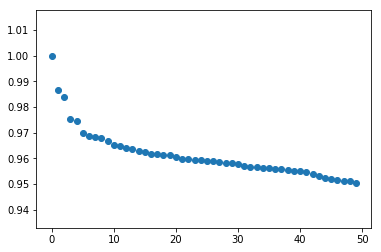

'\n# #Plot 1D projections; they are all standardized!\n# dm.plot_histogram(emap_naive, k=1)\n'

In [450]:
emap_naive, eigvals = dm.diffmap_proj(adj_mat, t=0, n_comps=reduced_dim, embed_type='naive', return_eigvals=True)
print("Laplacian eigenmap computed. Time: {}".format(time.time() - itime))
emap_heat = dm.diffmap_proj(adj_mat, n_comps=n_cmps, n_dims=reduced_dim, min_energy_frac=0.9, embed_type='diffmap', return_eigvals=False)
print("Diffusion components computed. Time: {}".format(time.time() - itime))

#Plot eigenvalue spectrum of resulting graph.
plt.scatter(x=range(reduced_dim), y=np.abs(eigvals)[:reduced_dim])
plt.show()

In [451]:
# Do t-SNE in diffusion component space.
ann_naive = adata.AnnData(X=emap_naive[:, :40])
ann_heat = adata.AnnData(X=emap_heat[:, :40])
itime = time.time()
sc.tl.tsne(ann_heat, use_rep='X')#, perplexity=30)
print(time.time() - itime)
itime = time.time()
sc.tl.tsne(ann_naive, use_rep='X')
print(time.time() - itime)

90.56874084472656
90.88595914840698


In [452]:
itime = time.time()
sc.pp.neighbors(ann_heat)
print(time.time() - itime)
itime = time.time()
sc.tl.umap(ann_heat)#, perplexity=30)
print(time.time() - itime)

12.910095691680908
25.986040115356445


In [453]:
naive_dm = emap_naive[:, :3].copy()
naive_tSNE = np.array(ann_naive.obsm['X_tsne'])
heat_dm = emap_heat[:, :3].copy()
heat_tSNE = np.array(ann_heat.obsm['X_tsne'])

#naive_tSNE = np.array(ann_naive.obsm['X_tsne'])
heat_umap = np.array(ann_heat.obsm['X_umap'])

vizdf = pd.DataFrame(data=np.hstack((naive_dm, naive_tSNE, 
                                     heat_dm, heat_tSNE, heat_umap
                                    )), 
                     columns=['EM_x', 'EM_y', 'EM_z', 'tSNE_x', 'tSNE_y', 
                              'hEM_x', 'hEM_y', 'hEM_z', 'htSNE_x', 'htSNE_y', 'hUMAP_x', 'hUMAP_y'
                             ], dtype='object')

vizdf['roarke_clusters'] = np.array([c.decode('utf-8') for c in c_roarke_clusters])
vizdf['top_enriched_clusters'] = np.array([c.decode('utf-8') for c in c_topenriched_clusters])
vizdf['gene_names'] = gene_names
vizdf['max_enrichments'] = max_agg_enrichments_bygene
vizdf.to_csv(vizdf_filename, sep="\t", index=False)

# At this point, vizdf contains the necessary info to be used in app_config.py.

# Addendum: how to whiten raw normalized essentiality data (CERES scores)

In [5]:
data_ess = pd.read_csv(_data_path + 'essentiality.tsv.gz', index_col=0, header=0, sep='\t')
data_ess = data_ess[data_ess.columns[:-4]]   # Only first 481 cols put through GLS, so isolate these
cell_line_names = data_ess.columns
cancer_types = data_ess.columns.str.split('_').str[1:].str.join(' ').str.capitalize().str.replace('Haematopoietic and lymphoid tissue', 'Hematopoietic/lymphoid')
ess_vals = data_ess.values

itime = time.time()
# Whiten data
U, s, Vt = np.linalg.svd(ess_vals.T, full_matrices=False)
ess_white = np.dot(U, Vt)
print(time.time() - itime)